In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import wandb
import pandas as pd

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ericjm (ericjmichaud_). Use `wandb login --relogin` to force relogin


True

## Dense TopK

In [3]:
api = wandb.Api()
run = api.run("ericjmichaud_/switch_saes_scaling_laws_attempt_0/lxo4heat")

run_names = list(run.config)
dict_sizes = {run_name: run.config[run_name]['dict_size'] for run_name in run_names}

history = run.scan_history()
data = pd.DataFrame(history)

In [4]:
# use FLOPS on the x axis
def flops_dense(step, activation_dim, dict_size, batch_size):
    forward = dict_size * activation_dim * 2 * batch_size
    backward = dict_size * activation_dim * 2 * batch_size
    return step * (forward + backward)

Text(0.5, 1.0, 'Dense TopK SAE training curves')

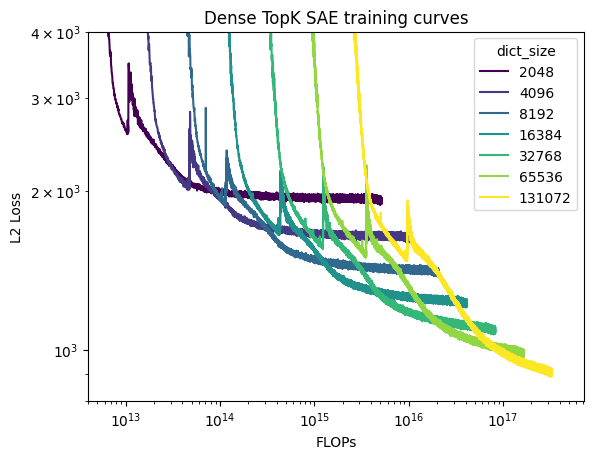

In [5]:
colors = plt.cm.viridis(np.linspace(0, 1, len(run_names)))
for i, run_name in enumerate(run_names):
    flops = flops_dense(
        np.array(data["_step"]),
        run.config[f"{run_name}"]["activation_dim"],
        run.config[f"{run_name}"]["dict_size"],
        # run.config[f"{run_name}"]["batch_size"]
        8192 # batch_size
    )
    losses = data[f"{run_name}/l2_loss"].values
    plt.plot(flops[:-1], losses[:-1], label=dict_sizes[run_name], color=colors[i])

plt.xscale('log')
plt.yscale('log')

plt.ylim(8e2, 4e3)
plt.xlim(4e12, None)

plt.xlabel("FLOPs")
plt.ylabel('L2 Loss')

plt.legend(title="dict_size")
plt.title("Dense TopK SAE training curves")


In [6]:
api = wandb.Api()
run8 = api.run("ericjmichaud_/switch_saes_scaling_laws_attempt_0/h6k7z6ra")

run_names8 = list(run8.config)
dict_sizes8 = {run_name: run8.config[run_name]['dict_size'] for run_name in run_names8}

history8 = run8.scan_history()
data8 = pd.DataFrame(history8)

In [7]:
api = wandb.Api()
run64 = api.run("ericjmichaud_/switch_saes_scaling_laws_attempt_0/ch2cr7og")

run_names64 = list(run64.config)
dict_sizes64 = {run_name: run64.config[run_name]['dict_size'] for run_name in run_names64}

history64 = run64.scan_history()
data64 = pd.DataFrame(history64)

In [9]:
# extremely crude calculation

# use FLOPS on the x axis
def flops_dense(step, activation_dim, dict_size, batch_size):
    forward = dict_size * activation_dim * 2 * batch_size
    backward = dict_size * activation_dim * 2 * batch_size
    return step * (forward + backward)

# use FLOPS on the x axis
def flops_sparse(step, activation_dim, dict_size, batch_size, experts):
    return flops_dense(step, activation_dim, dict_size, batch_size) / experts
    # forward = dict_size * activation_dim * 2 * batch_size / experts
    # backward = dict_size * activation_dim * 2 * batch_size / experts
    # return np.array(step) * (forward + backward)

Text(0.5, 1.0, 'Dense TopK SAE training curves')

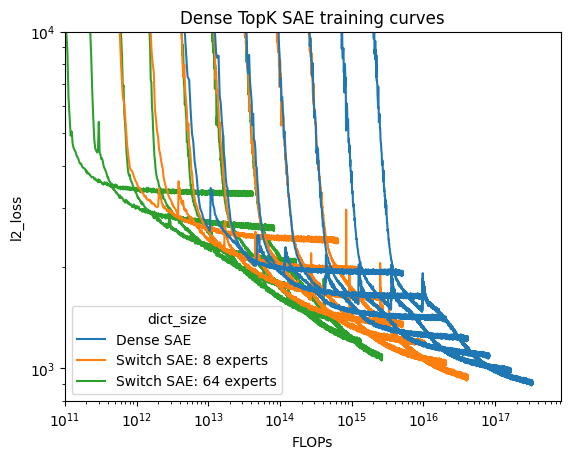

In [20]:
for i, run_name in enumerate(run_names):
    flops = flops_dense(
        np.array(data["_step"]),
        run.config[f"{run_name}"]["activation_dim"],
        run.config[f"{run_name}"]["dict_size"],
        # run.config[f"{run_name}"]["batch_size"]
        8192 # batch_size
    )
    losses = data[f"{run_name}/l2_loss"].values
    plt.plot(flops[:-1][::5], losses[:-1][::5], label='Dense SAE' if i == 0 else None, color='C0')

for i, run_name in enumerate(run_names8):
    flops = flops_sparse(
        np.array(data8[f"{run_name}/l2_loss"].index.tolist()),
        run8.config[f"{run_name}"]["activation_dim"],
        run8.config[f"{run_name}"]["dict_size"],
        # run8.config[f"{run_name}"]["batch_size"],
        8192, # batch_size
        8 # experts
    )
    # for some reason, the data run names are still AutoEncoderTopK, rather than SwitchAutoEncoder
    losses = data8[f"{run_name}/l2_loss"].values
    plt.plot(flops[:-1][::5], losses[:-1][::5], label='Switch SAE: 8 experts' if i == 0 else None, color='C1', zorder=-5)

for i, run_name in enumerate(run_names64):
    flops = flops_sparse(
        np.array(data64[f"{run_name}/l2_loss"].index.tolist()),
        run64.config[f"{run_name}"]["activation_dim"],
        run64.config[f"{run_name}"]["dict_size"],
        # run8.config[f"{run_name}"]["batch_size"],
        8192, # batch_size
        64 # experts
    )
    # for some reason, the data run names are still AutoEncoderTopK, rather than SwitchAutoEncoder
    losses = data64[f"{run_name}/l2_loss"].values
    plt.plot(flops[:-1][::5], losses[:-1][::5], label='Switch SAE: 64 experts' if i == 0 else None, color='C2', zorder=-10)

plt.xscale('log')
plt.yscale('log')

plt.xlim(1e11, None)
plt.ylim(8e2, 1e4)

plt.xlabel("FLOPs")
plt.ylabel('l2_loss')

plt.legend(title="dict_size")
plt.title("Dense TopK SAE training curves")


Text(0, 0.5, 'l2_loss')

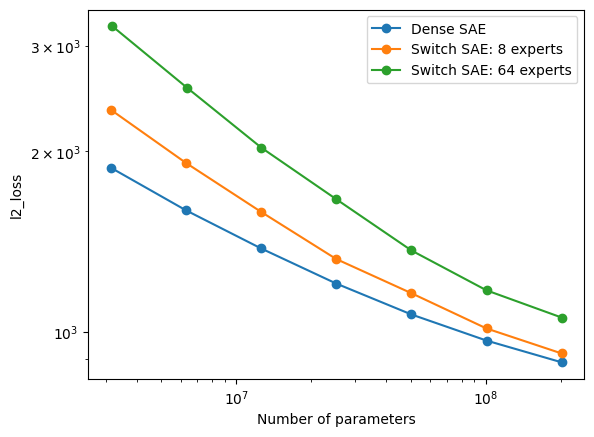

In [19]:
# plot parameter count vs. loss at the end of training

# dense
param_counts = []
losses = []
for run_name in run_names:
    activation_dim = run.config[f"{run_name}"]["activation_dim"]
    dict_size = run.config[f"{run_name}"]["dict_size"]
    P = dict_size * activation_dim * 2
    param_counts.append(P)
    losses.append(data[f"{run_name}/l2_loss"][:-1].min())

switch8_param_counts = []
switch8_losses = []
for run_name in run_names8:
    activation_dim = run8.config[f"{run_name}"]["activation_dim"]
    dict_size = run8.config[f"{run_name}"]["dict_size"]
    num_experts = 8
    P = dict_size * activation_dim * 2 + activation_dim * num_experts
    switch8_param_counts.append(P)
    switch8_losses.append(data8[f"{run_name}/l2_loss"][:-1].min())

switch64_param_counts = []
switch64_losses = []
for run_name in run_names64:
    activation_dim = run64.config[f"{run_name}"]["activation_dim"]
    dict_size = run64.config[f"{run_name}"]["dict_size"]
    num_experts = 64
    P = dict_size * activation_dim * 2 + activation_dim * num_experts
    switch64_param_counts.append(P)
    switch64_losses.append(data64[f"{run_name}/l2_loss"][:-1].min())

plt.plot(param_counts, losses, 'o-', label='Dense SAE', color='C0')
plt.plot(switch8_param_counts, switch8_losses, 'o-', label='Switch SAE: 8 experts', color='C1')
plt.plot(switch64_param_counts, switch64_losses, 'o-', label='Switch SAE: 64 experts', color='C2')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of parameters')
plt.ylabel('l2_loss')

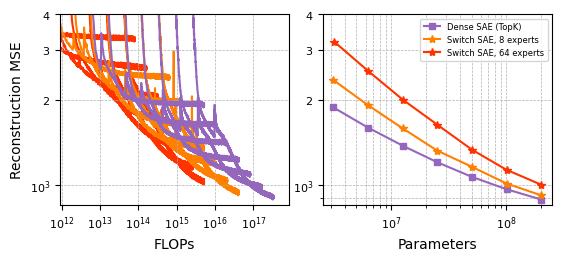

In [84]:
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(5.5, 2.5))

# ---- Left Plot ----
ax1 = plt.subplot(1, 2, 1)

# Plotting Dense SAE
for i, run_name in enumerate(run_names):
    flops = flops_dense(
        np.array(data["_step"]),
        run.config[f"{run_name}"]["activation_dim"],
        run.config[f"{run_name}"]["dict_size"],
        8192  # batch_size
    )
    losses = data[f"{run_name}/l2_loss"].values
    ax1.plot(flops[:-1][::5], losses[:-1][::5], label='Dense SAE' if i == 0 else None, color='C4')

# Plotting Switch SAE with 8 experts
for i, run_name in enumerate(run_names8):
    flops = flops_sparse(
        np.array(data8[f"{run_name}/l2_loss"].index.tolist()),
        run8.config[f"{run_name}"]["activation_dim"],
        run8.config[f"{run_name}"]["dict_size"],
        8192,  # batch_size
        8      # experts
    )
    losses = data8[f"{run_name}/l2_loss"].values
    ax1.plot(flops[:-1][::5], losses[:-1][::5], label='Switch SAE: 8 experts' if i == 0 else None, color=plt.cm.autumn(0.5), zorder=-5)

# Plotting Switch SAE with 64 experts
for i, run_name in enumerate(run_names64):
    flops = flops_sparse(
        np.array(data64[f"{run_name}/l2_loss"].index.tolist()),
        run64.config[f"{run_name}"]["activation_dim"],
        run64.config[f"{run_name}"]["dict_size"],
        8192,  # batch_size
        64     # experts
    )
    losses = data64[f"{run_name}/l2_loss"].values
    ax1.plot(flops[:-1][::5], losses[:-1][::5], label='Switch SAE: 64 experts' if i == 0 else None, color=plt.cm.autumn(0.2), zorder=-10)

# Setting scales and limits
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(9e11, None)
ax1.set_ylim(8.5e2, 4e3)
ax1.set_yticks([1e3, 2e3, 3e3, 4e3])
ax1.set_yticklabels([r"$10^3$", r"$2$", r"$3$", r"$4$"])

# Optionally, adjust tick label size
ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)

# Labels
ax1.set_xlabel("FLOPs", fontsize=10)
ax1.set_ylabel('Reconstruction MSE', fontsize=10)

# Optional: Remove minor ticks
ax1.minorticks_off()

ax1.grid(True, which="both", ls="--", linewidth=0.5)

# ---- Right Plot ----
ax2 = plt.subplot(1, 2, 2)

# Plotting parameter counts vs. losses
# Dense
param_counts = []
losses_dense = []
for run_name in run_names:
    activation_dim = run.config[f"{run_name}"]["activation_dim"]
    dict_size = run.config[f"{run_name}"]["dict_size"]
    P = dict_size * activation_dim * 2
    param_counts.append(P)
    losses_dense.append(data[f"{run_name}/l2_loss"][:-1].min())

# Switch SAE with 8 experts
switch8_param_counts = []
switch8_losses = []
for run_name in run_names8:
    activation_dim = run8.config[f"{run_name}"]["activation_dim"]
    dict_size = run8.config[f"{run_name}"]["dict_size"]
    num_experts = 8
    P = dict_size * activation_dim * 2 + activation_dim * num_experts
    switch8_param_counts.append(P)
    switch8_losses.append(data8[f"{run_name}/l2_loss"][:-1].min())

# Switch SAE with 64 experts
switch64_param_counts = []
switch64_losses = []
for run_name in run_names64:
    activation_dim = run64.config[f"{run_name}"]["activation_dim"]
    dict_size = run64.config[f"{run_name}"]["dict_size"]
    num_experts = 64
    P = dict_size * activation_dim * 2 + activation_dim * num_experts
    switch64_param_counts.append(P)
    switch64_losses.append(data64[f"{run_name}/l2_loss"][:-1].min())

# Plotting
ax2.plot(param_counts, losses_dense, 's-', label='Dense SAE (TopK)', color='C4', markersize=5)
ax2.plot(switch8_param_counts, switch8_losses, '*-', label='Switch SAE, 8 experts', color=plt.cm.autumn(0.5))
ax2.plot(switch64_param_counts, switch64_losses, '*-', label='Switch SAE, 64 experts', color=plt.cm.autumn(0.2))

# Setting scales
ax2.set_xscale('log')
ax2.set_yscale('log')

# add y tick labels manually
ax2.set_yticks([1e3, 2e3, 3e3, 4e3])
ax2.set_yticklabels([r"$10^3$", r"$2$", r"$3$", r"$4$"])
ax2.set_ylim(8.5e2, 4e3)

# Setting tick sizes
ax2.tick_params(axis='both', labelsize=8)

# Labels
ax2.set_xlabel('Parameters', fontsize=10)
# ax2.set_ylabel('Reconstruction MSE', fontsize=8)  # Uncomment if ylabel is desired

# Grid and legend
ax2.grid(True, which="both", ls="--", linewidth=0.5)
ax2.legend(loc='upper right', prop={'size': 6})

# Adjust layout
plt.tight_layout(pad=0.3)
# plt.subplots_adjust(wspace=0.2)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.87, bottom=0.1)

plt.savefig("switch_sae_scaling_laws.pdf")

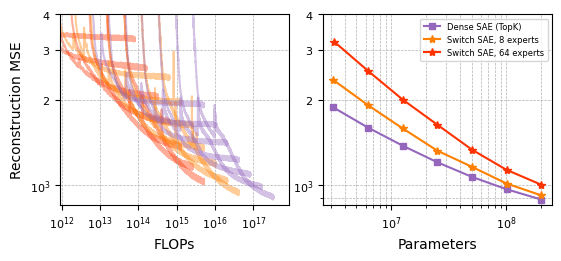

In [87]:
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(5.5, 2.5))

# ---- Left Plot ----
ax1 = plt.subplot(1, 2, 1)

# Plotting Dense SAE
for i, run_name in enumerate(run_names):
    flops = flops_dense(
        np.array(data["_step"]),
        run.config[f"{run_name}"]["activation_dim"],
        run.config[f"{run_name}"]["dict_size"],
        8192  # batch_size
    )
    losses = data[f"{run_name}/l2_loss"].values
    ax1.plot(flops[:-1][::5], losses[:-1][::5], label='Dense SAE' if i == 0 else None, color='C4', alpha=0.4)

# Plotting Switch SAE with 8 experts
for i, run_name in enumerate(run_names8):
    flops = flops_sparse(
        np.array(data8[f"{run_name}/l2_loss"].index.tolist()),
        run8.config[f"{run_name}"]["activation_dim"],
        run8.config[f"{run_name}"]["dict_size"],
        8192,  # batch_size
        8      # experts
    )
    losses = data8[f"{run_name}/l2_loss"].values
    ax1.plot(flops[:-1][::5], losses[:-1][::5], label='Switch SAE: 8 experts' if i == 0 else None, color=plt.cm.autumn(0.5), zorder=-5, alpha=0.4)

# Plotting Switch SAE with 64 experts
for i, run_name in enumerate(run_names64):
    flops = flops_sparse(
        np.array(data64[f"{run_name}/l2_loss"].index.tolist()),
        run64.config[f"{run_name}"]["activation_dim"],
        run64.config[f"{run_name}"]["dict_size"],
        8192,  # batch_size
        64     # experts
    )
    losses = data64[f"{run_name}/l2_loss"].values
    ax1.plot(flops[:-1][::5], losses[:-1][::5], label='Switch SAE: 64 experts' if i == 0 else None, color=plt.cm.autumn(0.2), zorder=-10, alpha=0.4)

# Setting scales and limits
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(9e11, None)
ax1.set_ylim(8.5e2, 4e3)
ax1.set_yticks([1e3, 2e3, 3e3, 4e3])
ax1.set_yticklabels([r"$10^3$", r"$2$", r"$3$", r"$4$"])

# Optionally, adjust tick label size
ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)

# Labels
ax1.set_xlabel("FLOPs", fontsize=10)
ax1.set_ylabel('Reconstruction MSE', fontsize=10)

# Optional: Remove minor ticks
ax1.minorticks_off()

ax1.grid(True, which="both", ls="--", linewidth=0.5)

# ---- Right Plot ----
ax2 = plt.subplot(1, 2, 2)

# Plotting parameter counts vs. losses
# Dense
param_counts = []
losses_dense = []
for run_name in run_names:
    activation_dim = run.config[f"{run_name}"]["activation_dim"]
    dict_size = run.config[f"{run_name}"]["dict_size"]
    P = dict_size * activation_dim * 2
    param_counts.append(P)
    losses_dense.append(data[f"{run_name}/l2_loss"][:-1].min())

# Switch SAE with 8 experts
switch8_param_counts = []
switch8_losses = []
for run_name in run_names8:
    activation_dim = run8.config[f"{run_name}"]["activation_dim"]
    dict_size = run8.config[f"{run_name}"]["dict_size"]
    num_experts = 8
    P = dict_size * activation_dim * 2 + activation_dim * num_experts
    switch8_param_counts.append(P)
    switch8_losses.append(data8[f"{run_name}/l2_loss"][:-1].min())

# Switch SAE with 64 experts
switch64_param_counts = []
switch64_losses = []
for run_name in run_names64:
    activation_dim = run64.config[f"{run_name}"]["activation_dim"]
    dict_size = run64.config[f"{run_name}"]["dict_size"]
    num_experts = 64
    P = dict_size * activation_dim * 2 + activation_dim * num_experts
    switch64_param_counts.append(P)
    switch64_losses.append(data64[f"{run_name}/l2_loss"][:-1].min())

# Plotting
ax2.plot(param_counts, losses_dense, 's-', label='Dense SAE (TopK)', color='C4', markersize=5)
ax2.plot(switch8_param_counts, switch8_losses, '*-', label='Switch SAE, 8 experts', color=plt.cm.autumn(0.5))
ax2.plot(switch64_param_counts, switch64_losses, '*-', label='Switch SAE, 64 experts', color=plt.cm.autumn(0.2))

# Setting scales
ax2.set_xscale('log')
ax2.set_yscale('log')

# add y tick labels manually
ax2.set_yticks([1e3, 2e3, 3e3, 4e3])
ax2.set_yticklabels([r"$10^3$", r"$2$", r"$3$", r"$4$"])
ax2.set_ylim(8.5e2, 4e3)

# Setting tick sizes
ax2.tick_params(axis='both', labelsize=8)

# Labels
ax2.set_xlabel('Parameters', fontsize=10)
# ax2.set_ylabel('Reconstruction MSE', fontsize=8)  # Uncomment if ylabel is desired

# Grid and legend
ax2.grid(True, which="both", ls="--", linewidth=0.5)
ax2.legend(loc='upper right', prop={'size': 6})

# Adjust layout
plt.tight_layout(pad=0.3)
# plt.subplots_adjust(wspace=0.2)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.87, bottom=0.1)

# plt.savefig("switch_sae_scaling_laws.pdf")

In [ ]:
# plot tSNE brain map of the switch SAEs

In [74]:
np.array(data8[f"AutoEncoderTopK-{i}/loss"].index.tolist()), run8.config[f"{run_name}"]["activation_dim"], run8.config[f"{run_name}"]["dict_size"],

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177